### TANZANIAN WATER WELLS

#### OVERVIEW

#### BUSINESS UNDERSTANDING

#### IMPORT LIBRARIES & DATA

In [3]:
# importing the neccessary libraries 
# Import relevant Python modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.model_selection import cross_val_predict, cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Scalers
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, LabelBinarizer, label_binarize

from sklearn.preprocessing import OneHotEncoder

In [4]:
# importing the csv files
labels = pd.read_csv('data\Training_set_labels.csv')

df = pd.read_csv('data/Training_set_values.csv')


In [5]:
#checking the shape of the dataframes
print('df: ', df.shape)
print('labels: ',labels.shape)

df:  (59400, 40)
labels:  (59400, 2)


In [6]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [7]:
labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [8]:
df.loc[df['id'] != labels['id']]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group


In [9]:
#merge the 2 dataframes
full_df = df.merge(labels)
full_df.shape

(59400, 41)

In [10]:
#checking the merge with a specific id
full_df.loc[full_df['id'] == 8776] 

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [11]:
#checking the y classes
full_df['status_group'].value_counts()

status_group
functional                 32259
non functional             22824
functional needs repair     4317
Name: count, dtype: int64

In [12]:
#grouping the values
full_df['status'] = np.where(full_df['status_group'] == "functional needs repair", 
                                'functional', full_df['status_group'])
full_df['status'].value_counts()

status
functional        36576
non functional    22824
Name: count, dtype: int64

In [13]:
#binary grouping
full_df['binary_status'] = np.where(full_df['status'] == 'functional', 1, 0)
full_df['binary_status'].value_counts()

binary_status
1    36576
0    22824
Name: count, dtype: int64

In [14]:
full_df.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3637
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     2
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3878
scheme_name              28810
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

#### DATA CLEANING

In [15]:
#dropping this value
full_df['scheme_management'].value_counts() 

scheme_management
VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
Name: count, dtype: int64

In [16]:
#new dataframe that without unnesseasary columns 
df_1 = full_df.drop(['status', 'status_group', 'waterpoint_type', 'source', 'payment_type', 
              'date_recorded', 'water_quality', 'quantity', 'num_private', 
                         'management_group', 'extraction_type_group', 
                         'extraction_type', 'recorded_by', 'latitude',
                        'longitude', 'lga', 'ward', 'scheme_name',
                        'region', 'subvillage', 'basin', 'wpt_name', 'public_meeting',
                        'gps_height', 'scheme_management'], axis = 1)

In [17]:
df_1.head(10)

,id,amount_tsh,funder,installer,region_code,district_code,population,permit,construction_year,extraction_type_class,management,payment,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,binary_status
0,69572,6000.0,Roman,Roman,11,5,109,False,1999,gravity,vwc,pay annually,good,enough,spring,groundwater,communal standpipe,1
1,8776,0.0,Grumeti,GRUMETI,20,2,280,True,2010,gravity,wug,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,1
2,34310,25.0,Lottery Club,World vision,21,4,250,True,2009,gravity,vwc,pay per bucket,good,enough,dam,surface,communal standpipe,1
3,67743,0.0,Unicef,UNICEF,90,63,58,True,1986,submersible,vwc,never pay,good,dry,borehole,groundwater,communal standpipe,0
4,19728,0.0,Action In A,Artisan,18,1,0,True,0,gravity,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,1
5,9944,20.0,Mkinga Distric Coun,DWE,4,8,1,True,2009,submersible,vwc,pay per bucket,salty,enough,other,unknown,communal standpipe,1
6,19816,0.0,Dwsp,DWSP,17,3,0,True,0,handpump,vwc,never pay,good,enough,borehole,groundwater,hand pump,0
7,54551,0.0,Rwssp,DWE,17,3,0,True,0,handpump,wug,unknown,milky,enough,shallow well,groundwater,hand pump,0
8,53934,0.0,Wateraid,Water Aid,14,6,0,True,0,handpump,vwc,never pay,salty,seasonal,borehole,groundwater,hand pump,0
9,46144,0.0,Isingiro Ho,Artisan,18,1,0,True,0,handpump,vwc,never pay,good,enough,shallow well,groundwater,hand pump,1


In [18]:
# checking the datatypes of the columns
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   funder                 55763 non-null  object 
 3   installer              55745 non-null  object 
 4   region_code            59400 non-null  int64  
 5   district_code          59400 non-null  int64  
 6   population             59400 non-null  int64  
 7   permit                 56344 non-null  object 
 8   construction_year      59400 non-null  int64  
 9   extraction_type_class  59400 non-null  object 
 10  management             59400 non-null  object 
 11  payment                59400 non-null  object 
 12  quality_group          59400 non-null  object 
 13  quantity_group         59400 non-null  object 
 14  source_type            59400 non-null  object 
 15  so

In [19]:
#changing the datatypes of some columns
df_1['region_code']= df_1['region_code'].astype(str)
df_1['district_code'] = df_1['district_code'].astype(str)
df_1['construction_year'] = df_1['construction_year'].astype(str)
df_1['amount_tsh'] = df_1['amount_tsh'].astype(int)
df_1['permit'] = np.where(df_1['permit'] == True, 1, df_1['permit'])
df_1['permit'] = np.where(df_1['permit'] == False, 0, df_1['permit'])
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     59400 non-null  int64 
 1   amount_tsh             59400 non-null  int32 
 2   funder                 55763 non-null  object
 3   installer              55745 non-null  object
 4   region_code            59400 non-null  object
 5   district_code          59400 non-null  object
 6   population             59400 non-null  int64 
 7   permit                 56344 non-null  object
 8   construction_year      59400 non-null  object
 9   extraction_type_class  59400 non-null  object
 10  management             59400 non-null  object
 11  payment                59400 non-null  object
 12  quality_group          59400 non-null  object
 13  quantity_group         59400 non-null  object
 14  source_type            59400 non-null  object
 15  source_class       

In [20]:
df_1.loc[((df_1['permit'] != 0) &
             (df_1['permit'] != 1))] #locating Null 
df_1.drop(df_1[(df_1['permit'] != 0) & 
                       (df_1['permit'] != 1)].index, inplace=True)
df_1['permit'] = df_1['permit'].astype(int)

In [21]:
df_1['source_type'].value_counts()

source_type
shallow well            16253
spring                  15981
borehole                11162
river/lake              10013
rainwater harvesting     2039
dam                       630
other                     266
Name: count, dtype: int64

In [22]:
df_1['extraction_type_class'].value_counts()

extraction_type_class
gravity         25234
handpump        16048
other            6050
submersible      5854
motorpump        2704
rope pump         349
wind-powered      105
Name: count, dtype: int64

In [23]:
df_1['funder'].value_counts()

funder
Government Of Tanzania    9043
Danida                    3112
Hesawa                    2027
Rwssp                     1372
World Bank                1345
                          ... 
Comune Di Roma               1
Swifti                       1
Area                         1
Rwi                          1
Samlo                        1
Name: count, Length: 1834, dtype: int64

In [24]:
df_1['installer'].value_counts()

installer
DWE              17361
Government        1788
RWE               1203
Commu             1060
DANIDA            1049
                 ...  
B.A.P                1
R                    1
Nasan workers        1
TWESS                1
SELEPTA              1
Name: count, Length: 2056, dtype: int64

In [25]:
df_1.loc[df_1['installer'] == '-']
# there's construction year 0

,id,amount_tsh,funder,installer,region_code,district_code,population,permit,construction_year,extraction_type_class,management,payment,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,binary_status
10217,42616,0,Kalebejo Parish,-,19,5,0,1,0,handpump,private operator,never pay,salty,insufficient,shallow well,groundwater,hand pump,1
20968,10873,0,Government Of Tanzania,-,19,5,0,1,0,other,vwc,pay per bucket,good,enough,river/lake,surface,communal standpipe,0
25769,21336,0,Government Of Tanzania,-,19,5,0,1,0,other,vwc,pay per bucket,good,enough,river/lake,surface,communal standpipe,1


In [26]:
df_1['construction_year'].value_counts() 
#dropping this column

construction_year
0       19580
2008     2576
2009     2491
2010     2430
2000     1566
2007     1559
2006     1447
2003     1276
2011     1211
2004     1109
2002     1065
1978     1027
2012     1026
2005      985
1995      979
1999      954
1985      943
1998      924
1984      779
1996      768
1982      741
1972      705
1994      703
1974      676
1990      667
1980      647
1992      632
1997      613
1993      595
2001      533
1988      521
1983      487
1975      437
1986      433
1976      411
1991      323
1989      316
1970      310
1987      301
1981      238
1977      199
1979      192
1973      183
2013      173
1971      145
1967       86
1963       85
1968       68
1969       59
1960       45
1964       40
1962       29
1961       20
1965       19
1966       17
Name: count, dtype: int64

In [27]:
df_1.drop(['construction_year'], axis = 1, inplace = True)

In [28]:
df_1['management'].value_counts()

management
vwc                 38296
wug                  6340
water board          2830
wua                  2468
private operator     1893
parastatal           1595
water authority       825
other                 744
company               658
unknown               519
other - school         99
trust                  77
Name: count, dtype: int64

In [29]:
df_1['quantity_group'].value_counts()

quantity_group
enough          31979
insufficient    13934
dry              5836
seasonal         3901
unknown           694
Name: count, dtype: int64

In [30]:
df_1['quality_group'].value_counts()

quality_group
good        48416
salty        5035
unknown      1399
milky         801
colored       490
fluoride      203
Name: count, dtype: int64

In [31]:
#dropping some specific wells
df_1.drop(df_1[(df_1['quantity_group'] == 'unknown') |
             (df_1['quality_group'] == 'unknown')].index, inplace=True)
df_1.shape

(54744, 17)

In [32]:
df_1['quantity_group'].value_counts()

quantity_group
enough          31851
insufficient    13830
dry              5202
seasonal         3861
Name: count, dtype: int64

In [33]:
df_1['quality_group'].value_counts()

quality_group
good        48246
salty        5007
milky         799
colored       489
fluoride      203
Name: count, dtype: int64

In [34]:
df_1['payment'].value_counts()

payment
never pay                23132
pay per bucket            8591
pay monthly               8167
unknown                   6628
pay when scheme fails     3728
pay annually              3533
other                      965
Name: count, dtype: int64

In [35]:
df_1.drop(['payment'], axis=1, inplace = True) 
#Dropping the payment column because it was initially thought to represent the cost of water, 
# but it actually indicates the payment method, which is not as useful for the goals of this project

In [36]:
df_1['amount_tsh'].value_counts()

amount_tsh
0         37625
500        3046
50         2310
1000       1431
20         1393
          ...  
53            1
138000        1
306           1
6300          1
59            1
Name: count, Length: 92, dtype: int64

In [37]:
df_1.info() #checking cleaned dataset

<class 'pandas.core.frame.DataFrame'>
Index: 54744 entries, 0 to 59399
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     54744 non-null  int64 
 1   amount_tsh             54744 non-null  int32 
 2   funder                 53632 non-null  object
 3   installer              53627 non-null  object
 4   region_code            54744 non-null  object
 5   district_code          54744 non-null  object
 6   population             54744 non-null  int64 
 7   permit                 54744 non-null  int32 
 8   extraction_type_class  54744 non-null  object
 9   management             54744 non-null  object
 10  quality_group          54744 non-null  object
 11  quantity_group         54744 non-null  object
 12  source_type            54744 non-null  object
 13  source_class           54744 non-null  object
 14  waterpoint_type_group  54744 non-null  object
 15  binary_status          5

In [38]:
df_1.shape

(54744, 16)

In [39]:
df_1.describe() #looking for outliers

,id,amount_tsh,population,permit,binary_status
count,54744.000000,54744.000000,54744.000000,54744.000000,54744.000000
mean,37099.038634,328.331452,180.584356,0.693190,0.626096
std,21448.518533,2685.603909,466.283047,0.461174,0.483843
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18502.500000,0.000000,0.000000,0.000000,0.000000
50%,37045.000000,0.000000,30.000000,1.000000,1.000000
75%,55627.500000,30.000000,220.000000,1.000000,1.000000
max,74247.000000,250000.000000,30500.000000,1.000000,1.000000


<Axes: >

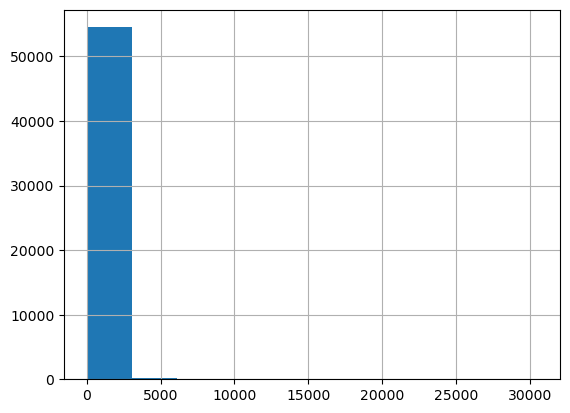

In [40]:
df_1['population'].hist()

<Axes: >

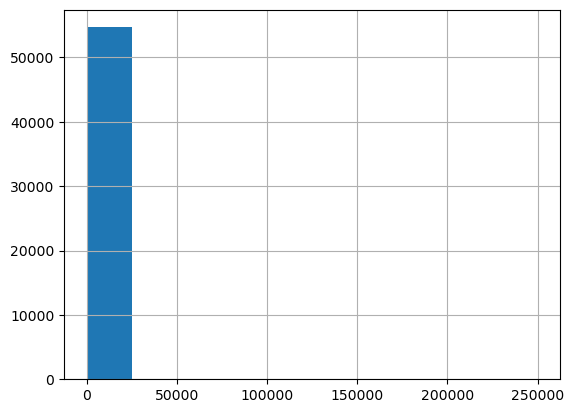

In [41]:
df_1['amount_tsh'].hist()

#### MODELLING

#### Dummy model

In [42]:
X = df_1.drop(['binary_status', 'id'], axis=1)
y = df_1['binary_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [43]:
y_train.value_counts(normalize=True)
#normalize to get the percentage breakdown

binary_status
1    0.626163
0    0.373837
Name: proportion, dtype: float64

In [44]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)
dummy_pred = dummy_model.predict(X_train)

In [45]:
f1_score(y_train, dummy_model.predict(X_train))

0.7701109829706292

#### DATA PROCESSING

In [46]:
X.dtypes #looking into data types of X 

amount_tsh                int32
funder                   object
installer                object
region_code              object
district_code            object
population                int64
permit                    int32
extraction_type_class    object
management               object
quality_group            object
quantity_group           object
source_type              object
source_class             object
waterpoint_type_group    object
dtype: object